<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter06/Road_sign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 6 - Road Sign Detection
- torch_snippets is a package of utilities to clean up the code from redundant stuff; written by the book authors (?)
- GTSRB sign database

Book Location 4768

Summary chart on Location 4853, shows impact of Augmentation & Batch-Norm on ths training job.  


In [1]:
import os
if not os.path.exists('GTSRB'):
    !pip install -U -q torch_snippets
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !unzip -qq GTSRB_Final_Training_Images.zip
    !unzip -qq GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip
    

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
--2020-12-14 21:37:28--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2020-12-14 21:37:28 (63.1 MB/s) - ‘signnames.csv’ saved [999/999]



## Run 1
- transformation pipeline WITHOUT augmentation
- COMMENTED OUT - BatchNorm2d - BatchNorm2d (no)

location 4812  summary chart @ location 4853  

Augmentation = no  
Batch-Norm = no  


2020-12-14 21:44:23.192 | INFO     | torch_snippets.loader:Glob:190 - 39209 files found at GTSRB/Final_Training/Images/*/*.ppm
2020-12-14 21:44:25.422 | INFO     | __main__:__init__:46 - 29406
2020-12-14 21:44:25.423 | INFO     | __main__:__init__:46 - 9803


EPOCH: 1.000	trn_loss: 2.285	trn_acc: 0.329	val_loss: 1.360	val_acc: 0.559	(23.68s - 923.50s remaining)
EPOCH: 2.000	trn_loss: 1.000	trn_acc: 0.671	val_loss: 0.848	val_acc: 0.728	(45.34s - 861.39s remaining)
EPOCH: 3.000	trn_loss: 0.679	trn_acc: 0.779	val_loss: 0.667	val_acc: 0.785	(66.95s - 825.69s remaining)
EPOCH: 4.000	trn_loss: 0.555	trn_acc: 0.816	val_loss: 0.597	val_acc: 0.803	(88.70s - 798.31s remaining)
EPOCH: 5.000	trn_loss: 0.470	trn_acc: 0.845	val_loss: 0.502	val_acc: 0.845	(110.44s - 773.08s remaining)
EPOCH: 6.000	trn_loss: 0.425	trn_acc: 0.861	val_loss: 0.452	val_acc: 0.853	(132.30s - 749.68s remaining)
EPOCH: 7.000	trn_loss: 0.389	trn_acc: 0.874	val_loss: 0.457	val_acc: 0.848	(154.04s - 726.18s remaining)
EPOCH: 8.000	trn_loss: 0.364	trn_acc: 0.884	val_loss: 0.362	val_acc: 0.884	(175.70s - 702.79s remaining)
EPOCH: 9.000	trn_loss: 0.339	trn_acc: 0.890	val_loss: 0.370	val_acc: 0.882	(197.47s - 680.17s remaining)
EPOCH: 10.000	trn_loss: 0.325	trn_acc: 0.893	val_loss: 0.41

  0%|          | 0/41 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 37%|███▋      | 15/41 [00:00<00:00, 143.50it/s]

EPOCH: 40.000	trn_loss: 0.111	trn_acc: 0.962	val_loss: 0.147	val_acc: 0.952	(874.82s - 0.00s remaining)


100%|██████████| 41/41 [00:00<00:00, 77.85it/s] 


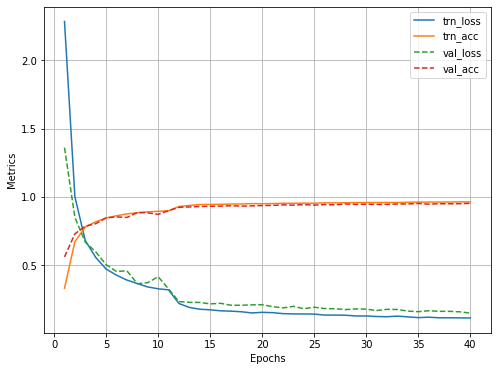

2020-12-14 21:59:05.259 | INFO     | torch_snippets.loader:dumpdill:324 - Dumped object @ no-aug-no-bn.log


In [2]:
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        #nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')

<class 'numpy.ndarray'>
Children crossing


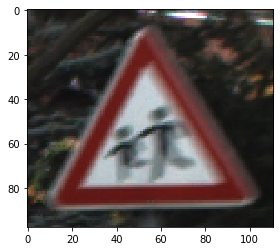

In [8]:
im, label = trn_ds[10]
print (type(im))
plt.imshow(im)
print (label)

# Run 2

## convBlock

- batchNorm2d(no)

Augmentation = no    
Batch-Norm = yes  

2020-12-14 22:12:07.880 | INFO     | torch_snippets.loader:Glob:190 - 39209 files found at GTSRB/Final_Training/Images/*/*.ppm
2020-12-14 22:12:07.893 | INFO     | __main__:__init__:46 - 29406
2020-12-14 22:12:07.894 | INFO     | __main__:__init__:46 - 9803


EPOCH: 1.000	trn_loss: 1.338	trn_acc: 0.601	val_loss: 0.560	val_acc: 0.820	(23.86s - 930.61s remaining)
EPOCH: 2.000	trn_loss: 0.428	trn_acc: 0.861	val_loss: 0.373	val_acc: 0.881	(47.88s - 909.77s remaining)
EPOCH: 3.000	trn_loss: 0.290	trn_acc: 0.903	val_loss: 0.269	val_acc: 0.911	(71.94s - 887.30s remaining)
EPOCH: 4.000	trn_loss: 0.227	trn_acc: 0.924	val_loss: 0.224	val_acc: 0.927	(96.13s - 865.13s remaining)
EPOCH: 5.000	trn_loss: 0.191	trn_acc: 0.936	val_loss: 0.207	val_acc: 0.934	(120.18s - 841.26s remaining)
EPOCH: 6.000	trn_loss: 0.174	trn_acc: 0.943	val_loss: 0.181	val_acc: 0.942	(144.26s - 817.50s remaining)
EPOCH: 7.000	trn_loss: 0.149	trn_acc: 0.951	val_loss: 0.165	val_acc: 0.947	(168.27s - 793.28s remaining)
EPOCH: 8.000	trn_loss: 0.140	trn_acc: 0.954	val_loss: 0.172	val_acc: 0.946	(192.38s - 769.51s remaining)
EPOCH: 9.000	trn_loss: 0.126	trn_acc: 0.958	val_loss: 0.159	val_acc: 0.948	(216.38s - 745.31s remaining)
EPOCH: 10.000	trn_loss: 0.120	trn_acc: 0.960	val_loss: 0.14

  0%|          | 0/41 [00:00<?, ?it/s]

EPOCH: 40.000	trn_loss: 0.019	trn_acc: 0.994	val_loss: 0.052	val_acc: 0.984	(961.71s - 0.00s remaining)


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 41/41 [00:00<00:00, 78.10it/s] 


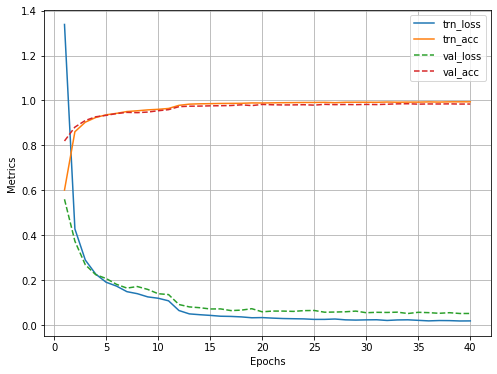

2020-12-14 22:28:12.309 | INFO     | torch_snippets.loader:dumpdill:324 - Dumped object @ no-aug-yes-bn.log


In [9]:
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-yes-bn.log')

## Run 3

Augmentation = yes  
Batch-Norm = yes  


2020-12-14 22:28:12.460 | INFO     | torch_snippets.loader:Glob:190 - 39209 files found at GTSRB/Final_Training/Images/*/*.ppm
2020-12-14 22:28:12.472 | INFO     | __main__:__init__:46 - 29406
2020-12-14 22:28:12.473 | INFO     | __main__:__init__:46 - 9803


EPOCH: 1.000	trn_loss: 1.847	trn_acc: 0.462	val_loss: 0.777	val_acc: 0.747	(40.61s - 1583.91s remaining)
EPOCH: 2.000	trn_loss: 0.692	trn_acc: 0.778	val_loss: 0.481	val_acc: 0.842	(81.24s - 1543.64s remaining)
EPOCH: 3.000	trn_loss: 0.498	trn_acc: 0.840	val_loss: 0.381	val_acc: 0.875	(121.92s - 1503.74s remaining)
EPOCH: 4.000	trn_loss: 0.403	trn_acc: 0.868	val_loss: 0.349	val_acc: 0.885	(162.20s - 1459.77s remaining)
EPOCH: 5.000	trn_loss: 0.339	trn_acc: 0.888	val_loss: 0.280	val_acc: 0.907	(202.79s - 1419.51s remaining)
EPOCH: 6.000	trn_loss: 0.309	trn_acc: 0.899	val_loss: 0.237	val_acc: 0.922	(243.27s - 1378.54s remaining)
EPOCH: 7.000	trn_loss: 0.278	trn_acc: 0.908	val_loss: 0.234	val_acc: 0.926	(283.84s - 1338.12s remaining)
EPOCH: 8.000	trn_loss: 0.251	trn_acc: 0.917	val_loss: 0.198	val_acc: 0.936	(324.23s - 1296.91s remaining)
EPOCH: 9.000	trn_loss: 0.229	trn_acc: 0.924	val_loss: 0.199	val_acc: 0.934	(364.74s - 1256.34s remaining)
EPOCH: 10.000	trn_loss: 0.216	trn_acc: 0.929	val

  0%|          | 0/41 [00:00<?, ?it/s]

EPOCH: 40.000	trn_loss: 0.065	trn_acc: 0.978	val_loss: 0.074	val_acc: 0.976	(1621.79s - 0.00s remaining)


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 41/41 [00:00<00:00, 75.34it/s] 


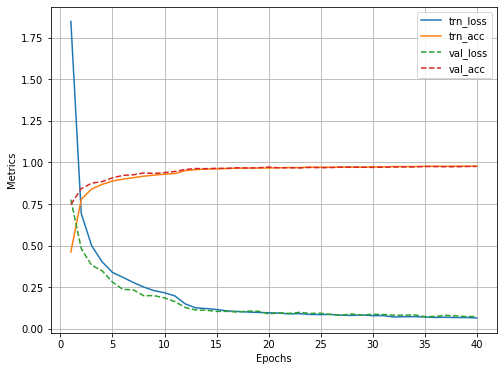

2020-12-14 22:55:16.993 | INFO     | torch_snippets.loader:dumpdill:324 - Dumped object @ 40-yes-aug-yes-bn.log


ModuleNotFoundError: No module named 'google.colab'

In [10]:
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2), 
    contrast=(0.8,1.2), 
    saturation=(0.8,1.2), 
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, '40-yes-aug-yes-bn.log')
from google.colab import files
files.download('40-yes-aug-yes-bn.log')

In [1]:
for f in Glob('*.log'):
    log = loaddill(f)
    print()
    log.report_avgs(20)
    log.plot_epochs(['trn_acc', 'val_acc'], title=f.replace(',','\n').replace('.log',''))
    print()
    line()

NameError: name 'Glob' is not defined